In [18]:
import numpy as np
import open3d as o3d
import os
import cv2
import matplotlib.pyplot as plt
import json

In [19]:
# edit here
# model_path = "/mnt/NAS/data/WenyuHan/sim2real/2022-11-15/Toyota/21092302/part_info/21092302.master.ply"
# data_path = '/mnt/NAS/data/WenyuHan/sim2real/2022-11-15/Toyota/21092302/2022-04-18-rvbust_bright_lighting_lux1600'
# idx_image = 10  # No. of instance, start from 0
# model_path = "/mnt/NAS/data/WenyuHan/sim2real/2022-11-15/Toyota/21092302/part_info/21092302.master.ply"
# data_path = '/mnt/NAS/data/WenyuHan/sim2real/2022-11-15/Toyota/21092302/2022-10-03-rvbust_synthetic'
# idx_image = 0  # No. of instance, start from 0
model_path = "/mnt/NAS/data/WenyuHan/sim2real/2022-11-15/SongFeng/SF-CJd60-097-016-016/part_info/SF-CJd60-097-016-016.master.ply"
data_path = '/mnt/NAS/data/WenyuHan/sim2real/2022-11-15/SongFeng/SF-CJd60-097-016-016/2022-04-19-rvbust_bright_lighting_lux1600'
idx_image = 1

In [20]:
# read model points
# Read the point cloud
pcd = o3d.io.read_point_cloud(model_path)
# Convert open3d format to numpy array
pcd = np.array(pcd.points)
pcd.shape

(77924, 3)

In [21]:
pcd.min(axis=0),  pcd.max(axis=0)
# seem .ply is in mm

(array([-119.84703827,  -77.59830475,   -6.97388935]),
 array([136.67584229,  70.45521545,   9.33849621]))

In [22]:
i = f'{idx_image:06}'
color_path = os.path.join(data_path, 'images', f'{i}.jpg')
depth_path = os.path.join(data_path, 'depth', f'{i}.png')
param_path = os.path.join(data_path, 'images', f'{i}.json')
label_path = os.path.join(data_path, 'labels', f'{i}.npy')

# read image
color = cv2.imread(color_path, cv2.IMREAD_COLOR)
depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
# read json
with open(param_path) as f:
    params = json.load(f)
K = params['K']
K = np.array(K)
K = K.reshape((3,3))
# read numpy
labels = np.load(label_path)

n_instances = len(labels)
n_instances

13

34032.183753425714 1596.65966796875 21.314613524822747
33102.72975371644 1545.747314453125 21.41535647139582
34099.61276828934 1582.4918212890625 21.548049923261253
33002.64401802103 1535.60595703125 21.491609788896785
34528.58181635523 1595.66455078125 21.638997870479585
33690.44582195614 1531.0142822265625 22.005311258729698
34532.22034012083 1578.532470703125 21.87615458093121
33618.397271028625 1532.2913818359375 21.93995063181015
33287.914472482924 1531.2928466796875 21.738437911899954
33209.95417064325 1531.292236328125 21.68753513064049
32951.33869366409 1502.4647216796875 21.93152239662971
32911.63909560103 1517.088134765625 21.69395326573136
32829.590794572214 1508.90625 21.75721042614292


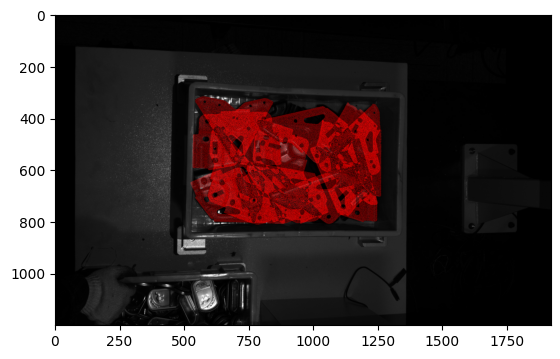

In [23]:
color2 = color.copy()
ones = np.ones((pcd.shape[0], 1))
pcd_one = np.concatenate([pcd, ones], axis=1)

# for each instance
for j in range(n_instances):
    # read pose label from .npy
    pose = labels[j]
    # transform model points -> check depth

    points = np.matmul(pose, pcd_one.transpose())
    # project model points to image
    pixels = np.matmul(K, points[:3] / points[2]).astype(int)[:2]
    pixels = np.unique(pixels, axis=1)
    pixels[[0,1]] = pixels[[1,0]]

    y_min, y_max, x_min, x_max = pixels[0].min(), pixels[0].max(), pixels[1].min(), pixels[1].max()
    
    patch = depth[y_min:y_max+1, x_min:x_max+1]
    mask = np.ma.getmaskarray(np.ma.masked_not_equal(patch, 0))
    # check depth
    print(patch.mean(where=mask), pose[2,3], patch.mean(where=mask) / pose[2,3])
    
    # mark the color
    for i in range(pixels.shape[1]):
        color2[pixels[0][i]][pixels[1][i]] += np.array([100,0,0], dtype=np.uint8)
# color2 = np.clip(color2, 0, 255)
plt.imshow(color2)

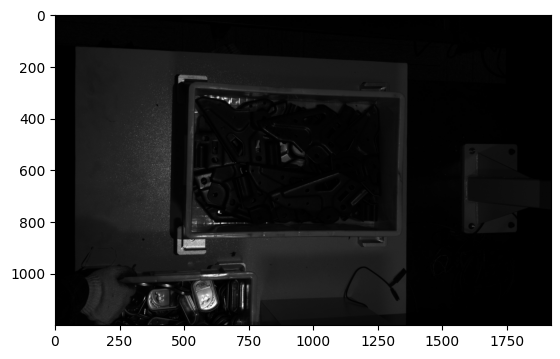

In [24]:
# compare
plt.imshow(color)

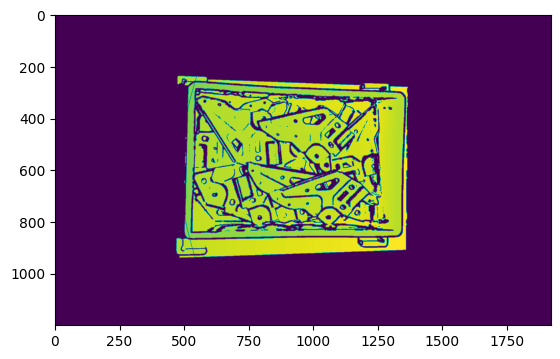

In [25]:
plt.imshow(depth)